### Dataset: https://www.kaggle.com/datasets/bhaveshmittal/melanoma-cancer-dataset?resource=download
### Tutorial: https://www.youtube.com/watch?v=V_xro1bcAuA&t=77134s
### Model: https://www.nature.com/articles/s41598-023-49075-4

In [1]:
!pip install tqdm
!pip install torchinfo

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import torch
from torch import nn
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import datasets, transforms, models
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from tqdm.auto import tqdm
from timeit import default_timer as timer
from typing import Tuple, Dict, List
import random
import os
torch.__version__

/home/jhajduk/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'2.2.1+cu121'

In [3]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu" 
device

'cuda'

In [5]:
!nvidia-smi

Mon Apr  8 21:35:53 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.60.01              Driver Version: 551.76         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080 Ti     On  |   00000000:01:00.0  On |                  N/A |
| 35%   40C    P8             31W /  400W |    1242MiB /  12288MiB |     12%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
IMAGE_PATH = "./data/melanoma"

In [7]:
def walk_through_dir(dir_path):
    for dirpath, dirnames, filesnames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filesnames)} images in '{dirpath}'")

walk_through_dir("./data")

In [8]:
image_dir = Path("../../datasets/melanoma")
train_dir = Path("../../datasets/melanoma/train")
test_dir = Path("../../datasets/melanoma/test")

Random image path: ../../datasets/melanoma/full_test/Malignant/5803.jpg
Image class is: Malignant
Image width: 224
Image height: 224


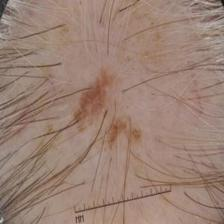

In [9]:
image_path_list = list(image_dir.glob("*/*/*.jpg"))
rand_image_path = random.choice(image_path_list)
image_class = rand_image_path.parent.stem
img = Image.open(rand_image_path)
print(f"Random image path: {rand_image_path}")
print(f"Image class is: {image_class}")
print(f"Image width: {img.width}")
print(f"Image height: {img.height}")
img

(-0.5, 223.5, 223.5, -0.5)

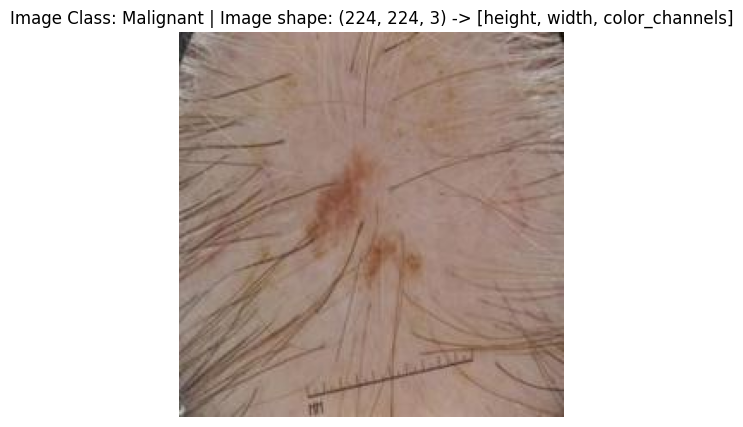

In [10]:
img_as_array = np.asarray(img)

plt.figure(figsize=(5,5))
plt.imshow(img_as_array)
plt.title(f"Image Class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)

In [11]:
img_as_array

array([[[ 65,  63,  66],
        [ 42,  40,  43],
        [ 55,  53,  56],
        ...,
        [ 40,  33,  25],
        [ 19,  12,   4],
        [ 35,  28,  20]],

       [[ 51,  49,  52],
        [ 47,  45,  48],
        [ 67,  65,  68],
        ...,
        [ 52,  45,  37],
        [ 24,  17,   9],
        [ 34,  27,  19]],

       [[ 48,  46,  49],
        [ 56,  54,  57],
        [ 72,  70,  73],
        ...,
        [ 64,  55,  48],
        [ 25,  18,  10],
        [ 18,  11,   3]],

       ...,

       [[201, 201, 193],
        [183, 183, 175],
        [142, 137, 131],
        ...,
        [123,  99,  87],
        [118,  94,  82],
        [111,  87,  75]],

       [[162, 162, 154],
        [145, 145, 137],
        [109, 104,  98],
        ...,
        [120,  93,  82],
        [116,  89,  78],
        [108,  81,  70]],

       [[105, 105,  97],
        [109, 109, 101],
        [ 95,  90,  84],
        ...,
        [116,  89,  78],
        [111,  84,  73],
        [100,  73,  62]]

In [12]:
data_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    #transforms.RandomHorizontalFlip(p=0.5), #Augmentation helps with overfitting, not whatever is going on here
    transforms.ToTensor()
])

In [13]:
data_transform(img).shape

torch.Size([3, 224, 224])

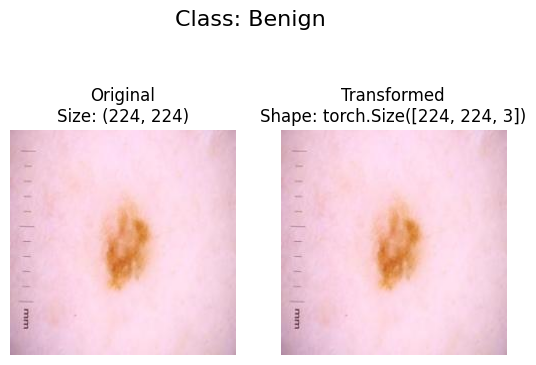

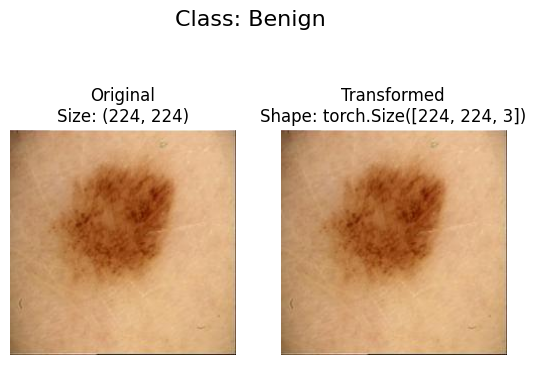

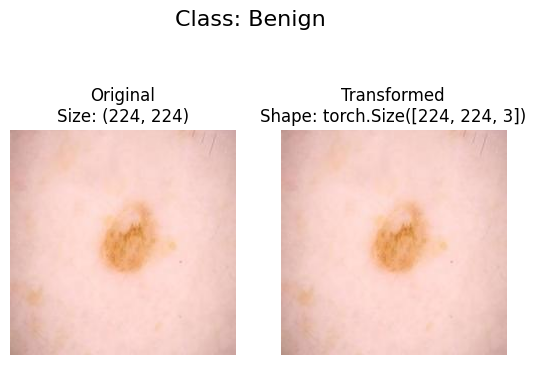

In [14]:
def plot_transformed_images(image_paths, transform, n=3):
    rand_image_paths = random.sample(image_paths, k=n)
    for image_path in rand_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            transformed_image = transform(f).permute(1,2,0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)
    
plot_transformed_images(image_paths=image_path_list, transform=data_transform, n=3)

In [15]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 200
     Root location: ../../datasets/melanoma/train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 200
     Root location: ../../datasets/melanoma/test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [16]:
classes = train_data.classes
classes

['Benign', 'Malignant']

In [17]:
class_dict = train_data.class_to_idx
class_dict

{'Benign': 0, 'Malignant': 1}

In [18]:
len(train_data), len(test_data)

(200, 200)

In [19]:
target_directory = train_dir
print(f"Target dir: {target_directory}")

class_names_found = sorted(entry.name for entry in list(os.scandir(target_directory)))
class_names_found

Target dir: ../../datasets/melanoma/train


['Benign', 'Malignant']

In [20]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    classes = sorted(entry.name for entry in os.scandir(target_directory) if entry.is_dir())

    if not classes:
        raise FileNotFoundError(f"Counld not find the classes. Check the directory: {directory}")
    
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    return classes, class_to_idx

print(find_classes(train_dir))

(['Benign', 'Malignant'], {'Benign': 0, 'Malignant': 1})


In [21]:
class ImageFolderCustom(Dataset):
    def __init__(self, targ_dir: str, transform=None):
        self.paths = list(Path(targ_dir).glob("*/*.jpg"))
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(targ_dir)
    
    def load_image(self, index: int) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path)
    
    def __len__(self) -> int:
        return len(self.paths)
    
    def __getitem__(self, index: int) -> Tuple[torch.tensor, int]:
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]
        
        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx


In [22]:
train_transforms = transforms.Compose([
    transforms.Resize(size=(128,128)),
    transforms.TrivialAugmentWide(num_magnitude_bins=30),
    transforms.ToTensor()
])
test_transforms = transforms.Compose([
    transforms.Resize(size=(128,128)),
    transforms.ToTensor()
])

In [23]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)


train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7fac5dd9bdf0>,
 <__main__.ImageFolderCustom at 0x7fad2c0d5b70>)

In [24]:
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True):
    random_samples_idx = random.sample(range(len(dataset)), k=n)
    plt.figure(figsize=(20,20))
    for i, targ_smaple in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_smaple][0], dataset[targ_smaple][1] 
        targ_image_adjust = targ_image.permute(1,2,0)
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis(False)
        if classes: 
            title = f"Class: {classes[targ_label]}"
            if display_shape:
                title += f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

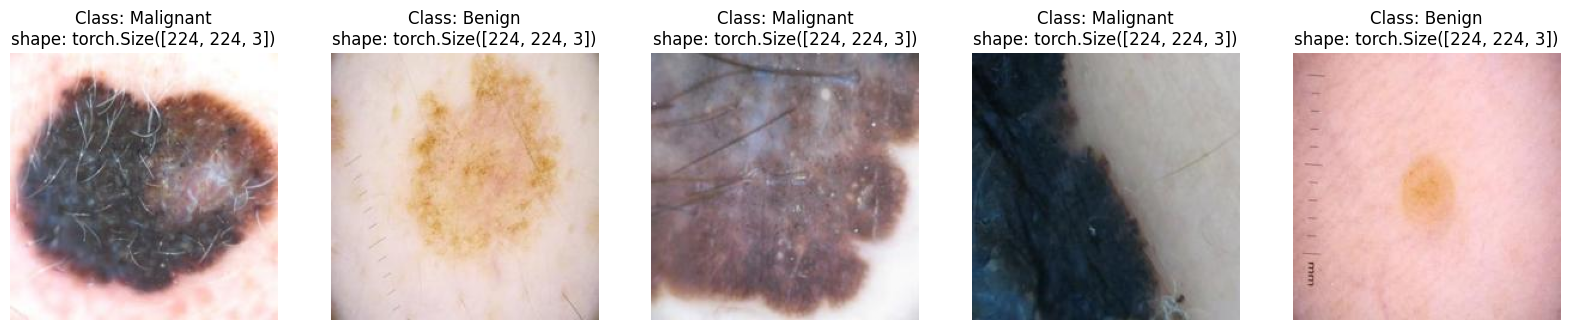

In [25]:
display_random_images(train_data,
                      n=5,
                      classes=train_data.classes)

In [26]:
BATCH_SIZE=32
NUM_WORKERS = os.cpu_count()
train_data_loader_custom = DataLoader(dataset=train_data_custom,
                                      batch_size=BATCH_SIZE,
                                      num_workers=NUM_WORKERS,
                                      shuffle=True)

test_data_loader_custom = DataLoader(dataset=test_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=False)

In [27]:
img_custom, label_custom = next(iter(train_data_loader_custom))

img_custom.shape, label_custom.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

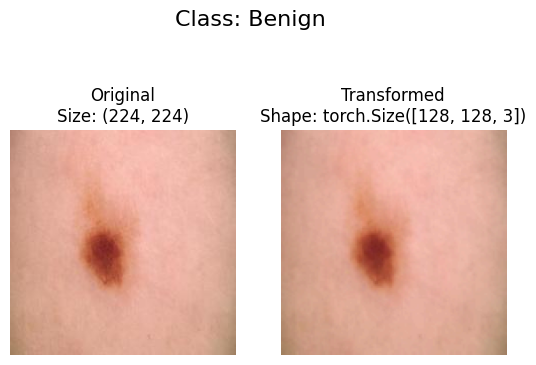

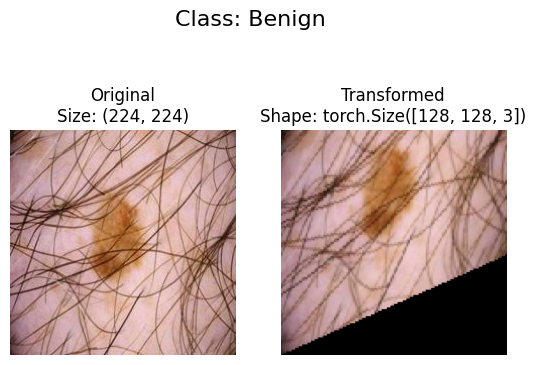

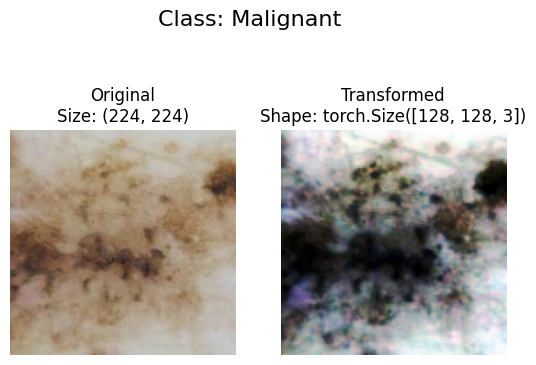

In [28]:
plot_transformed_images(image_paths=image_path_list,
                        transform=train_transforms,
                        n=3)

In [29]:
model = models.resnet18(pretrained=True)
for params in model.parameters():
  params.requires_grad_ = False
nr_filters = model.fc.in_features
model.fc = nn.Linear(nr_filters, 2)

model = model.to(device)

/home/jhajduk/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jhajduk/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [30]:
def train_step(model: torch.nn.Module,
          dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          device=device):
    
    model.train()

    train_loss, train_acc = 0, 0
    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += ((y_pred_class == y).sum().item()/len(y_pred))

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    
    return train_loss, train_acc

In [31]:
def test_step(model: torch.nn.Module,
          dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          device=device):
    
    model.eval()
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X_test, y_test) in enumerate(dataloader):
            X_test, y_test = X_test.to(device), y_test.to(device)
            test_pred = model(X_test)
            loss = loss_fn(test_pred, y_test)
            test_loss += loss.item()
            test_pred_labels = test_pred.argmax(dim=1)
            test_acc += ((test_pred_labels == y_test).sum().item()/len(test_pred_labels))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc


In [32]:
def trainer_model(model: torch.nn.Module,
            train_dataloader: torch.utils.data.DataLoader,
            test_dataloader: torch.utils.data.DataLoader,
            loss_fn: torch.nn.Module,
            optimizer: torch.optim.Optimizer,
            epochs: int = 5,
            device=device):
    
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, device=device)
        test_loss, test_acc = test_step(model=model, dataloader=test_dataloader, loss_fn=loss_fn, device=device)
        print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    return results
    

In [33]:
LEARNING_RATE = 0.0001
EPOCHS = 25
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [34]:
start_time = timer()
model_results = trainer_model(model=model,
                        train_dataloader=train_data_loader_custom,
                        test_dataloader=test_data_loader_custom,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        epochs=EPOCHS,
                        device=device)
end_time = timer()
print(f"Total Training Time: {end_time-start_time:.3f} seconds on {device}")

  0%|          | 0/25 [00:00<?, ?it/s]

  4%|▍         | 1/25 [00:02<01:11,  2.96s/it]

Epoch: 0 | Train Loss: 0.6082 | Train Accuracy: 0.6920 | Test Loss: 0.6065 | Test Accuracy: 0.6518


  8%|▊         | 2/25 [00:05<00:56,  2.48s/it]

Epoch: 1 | Train Loss: 0.3656 | Train Accuracy: 0.8214 | Test Loss: 0.4618 | Test Accuracy: 0.7991


 12%|█▏        | 3/25 [00:07<00:50,  2.32s/it]

Epoch: 2 | Train Loss: 0.2409 | Train Accuracy: 0.8795 | Test Loss: 0.4360 | Test Accuracy: 0.8080


 16%|█▌        | 4/25 [00:09<00:48,  2.32s/it]

Epoch: 3 | Train Loss: 0.2687 | Train Accuracy: 0.8884 | Test Loss: 0.3553 | Test Accuracy: 0.8527


 20%|██        | 5/25 [00:11<00:46,  2.31s/it]

Epoch: 4 | Train Loss: 0.2368 | Train Accuracy: 0.9018 | Test Loss: 0.3438 | Test Accuracy: 0.8527


 24%|██▍       | 6/25 [00:14<00:43,  2.31s/it]

Epoch: 5 | Train Loss: 0.2239 | Train Accuracy: 0.9152 | Test Loss: 0.3516 | Test Accuracy: 0.8393


 28%|██▊       | 7/25 [00:16<00:41,  2.30s/it]

Epoch: 6 | Train Loss: 0.1522 | Train Accuracy: 0.9420 | Test Loss: 0.3754 | Test Accuracy: 0.8527


 32%|███▏      | 8/25 [00:18<00:39,  2.32s/it]

Epoch: 7 | Train Loss: 0.2249 | Train Accuracy: 0.9196 | Test Loss: 0.4115 | Test Accuracy: 0.8304


 36%|███▌      | 9/25 [00:21<00:37,  2.31s/it]

Epoch: 8 | Train Loss: 0.1854 | Train Accuracy: 0.9107 | Test Loss: 0.4058 | Test Accuracy: 0.8259


 40%|████      | 10/25 [00:23<00:34,  2.27s/it]

Epoch: 9 | Train Loss: 0.2002 | Train Accuracy: 0.8929 | Test Loss: 0.5948 | Test Accuracy: 0.7723


 44%|████▍     | 11/25 [00:25<00:32,  2.29s/it]

Epoch: 10 | Train Loss: 0.2019 | Train Accuracy: 0.9152 | Test Loss: 0.6956 | Test Accuracy: 0.7545


 48%|████▊     | 12/25 [00:27<00:29,  2.29s/it]

Epoch: 11 | Train Loss: 0.1158 | Train Accuracy: 0.9688 | Test Loss: 0.5347 | Test Accuracy: 0.7946


 52%|█████▏    | 13/25 [00:30<00:27,  2.30s/it]

Epoch: 12 | Train Loss: 0.1020 | Train Accuracy: 0.9732 | Test Loss: 0.5331 | Test Accuracy: 0.7946


 56%|█████▌    | 14/25 [00:32<00:25,  2.31s/it]

Epoch: 13 | Train Loss: 0.1427 | Train Accuracy: 0.9509 | Test Loss: 0.5635 | Test Accuracy: 0.8125


 60%|██████    | 15/25 [00:34<00:22,  2.30s/it]

Epoch: 14 | Train Loss: 0.2566 | Train Accuracy: 0.9062 | Test Loss: 0.6667 | Test Accuracy: 0.7321


 64%|██████▍   | 16/25 [00:37<00:20,  2.29s/it]

Epoch: 15 | Train Loss: 0.0572 | Train Accuracy: 0.9821 | Test Loss: 0.5865 | Test Accuracy: 0.8170


 68%|██████▊   | 17/25 [00:39<00:18,  2.28s/it]

Epoch: 16 | Train Loss: 0.1113 | Train Accuracy: 0.9509 | Test Loss: 0.6148 | Test Accuracy: 0.8214


 72%|███████▏  | 18/25 [00:41<00:16,  2.29s/it]

Epoch: 17 | Train Loss: 0.0684 | Train Accuracy: 0.9777 | Test Loss: 0.6535 | Test Accuracy: 0.8214


 76%|███████▌  | 19/25 [00:43<00:13,  2.29s/it]

Epoch: 18 | Train Loss: 0.1310 | Train Accuracy: 0.9509 | Test Loss: 0.6463 | Test Accuracy: 0.8125


 80%|████████  | 20/25 [00:46<00:11,  2.29s/it]

Epoch: 19 | Train Loss: 0.1182 | Train Accuracy: 0.9464 | Test Loss: 0.5397 | Test Accuracy: 0.8705


 84%|████████▍ | 21/25 [00:48<00:09,  2.28s/it]

Epoch: 20 | Train Loss: 0.1483 | Train Accuracy: 0.9375 | Test Loss: 0.5695 | Test Accuracy: 0.8214


 88%|████████▊ | 22/25 [00:50<00:06,  2.25s/it]

Epoch: 21 | Train Loss: 0.1336 | Train Accuracy: 0.9375 | Test Loss: 0.5872 | Test Accuracy: 0.8259


 92%|█████████▏| 23/25 [00:53<00:04,  2.31s/it]

Epoch: 22 | Train Loss: 0.1501 | Train Accuracy: 0.9107 | Test Loss: 0.7572 | Test Accuracy: 0.7589


 96%|█████████▌| 24/25 [00:55<00:02,  2.30s/it]

Epoch: 23 | Train Loss: 0.0600 | Train Accuracy: 0.9821 | Test Loss: 0.6623 | Test Accuracy: 0.7634


100%|██████████| 25/25 [00:57<00:00,  2.31s/it]

Epoch: 24 | Train Loss: 0.1581 | Train Accuracy: 0.9330 | Test Loss: 0.7824 | Test Accuracy: 0.7500
Total Training Time: 57.712 seconds on cuda


In [35]:
model_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

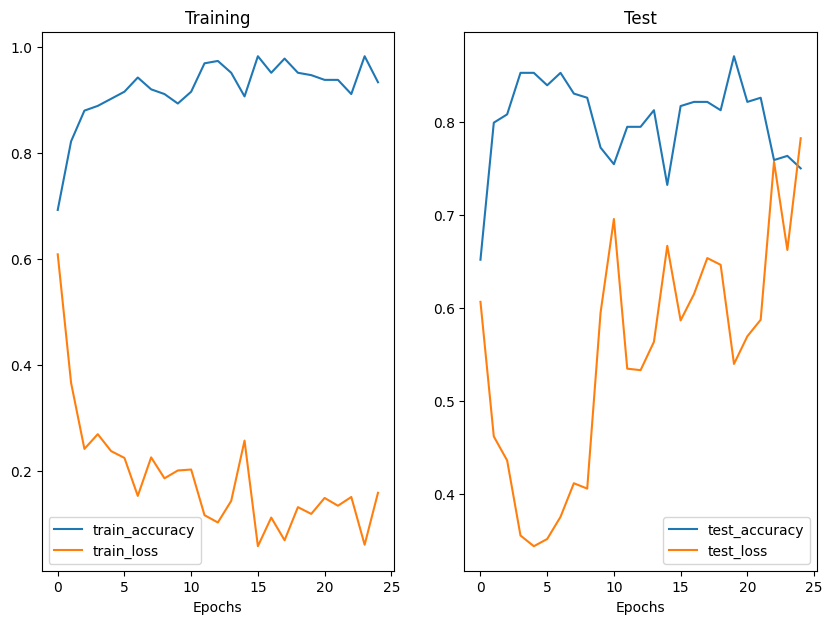

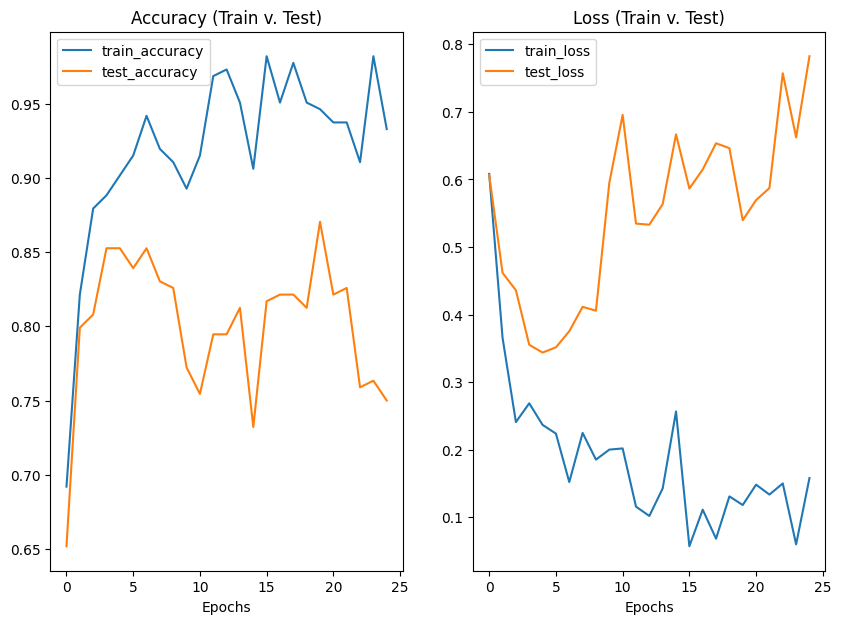

In [43]:
def plot_results_dict(results: Dict[str, List[float]]):
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(10,7))
    plt.subplot(1,2,1)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, loss, label="train_loss")
    plt.title("Training")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Test")
    plt.xlabel("Epochs")
    plt.legend()

    plt.figure(figsize=(10,7))
    plt.subplot(1,2,1)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy (Train v. Test)")
    plt.xlabel("Epochs")
    plt.legend()

    
    plt.subplot(1,2,2)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss (Train v. Test)")
    plt.xlabel("Epochs")
    plt.legend()

plot_results_dict(model_results)

In [37]:
custom_test_image_path = Path("../../datasets/melanoma/full_test/Malignant/5602.jpg")
custom_image = torchvision.io.read_image(str(custom_test_image_path)).type(torch.float32) / 255

custom_image

tensor([[[0.5608, 0.5647, 0.5686,  ..., 0.4392, 0.4314, 0.4275],
         [0.5647, 0.5686, 0.5765,  ..., 0.4431, 0.4353, 0.4314],
         [0.5725, 0.5725, 0.5882,  ..., 0.4510, 0.4431, 0.4392],
         ...,
         [0.3922, 0.3922, 0.3922,  ..., 0.5608, 0.5569, 0.5569],
         [0.3843, 0.3882, 0.3882,  ..., 0.5569, 0.5490, 0.5451],
         [0.3804, 0.3843, 0.3843,  ..., 0.5569, 0.5451, 0.5451]],

        [[0.4275, 0.4314, 0.4353,  ..., 0.2275, 0.2196, 0.2157],
         [0.4314, 0.4353, 0.4431,  ..., 0.2314, 0.2235, 0.2196],
         [0.4353, 0.4353, 0.4431,  ..., 0.2314, 0.2235, 0.2196],
         ...,
         [0.1529, 0.1529, 0.1529,  ..., 0.3490, 0.3412, 0.3412],
         [0.1451, 0.1490, 0.1490,  ..., 0.3451, 0.3451, 0.3412],
         [0.1412, 0.1451, 0.1451,  ..., 0.3451, 0.3412, 0.3412]],

        [[0.3922, 0.3961, 0.4000,  ..., 0.2196, 0.2118, 0.2078],
         [0.3961, 0.4000, 0.4078,  ..., 0.2235, 0.2157, 0.2118],
         [0.4118, 0.4118, 0.4196,  ..., 0.2275, 0.2196, 0.

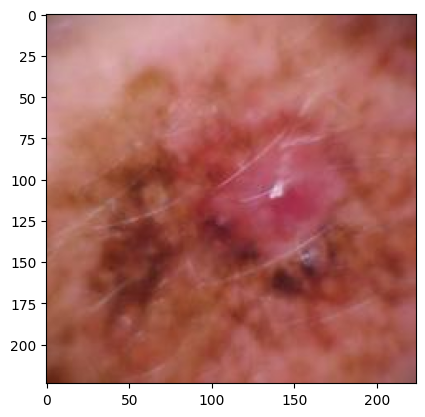

In [38]:
plt.imshow(custom_image.permute(1,2,0))

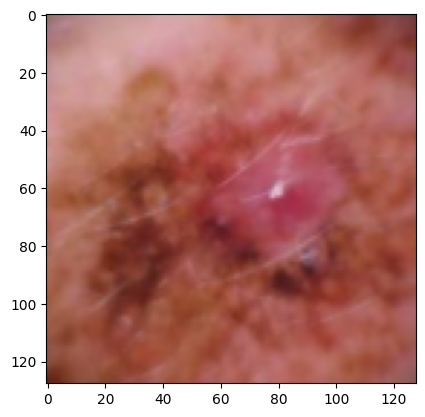

In [39]:
custom_image_transform = transforms.Compose([transforms.Resize(size=(128,128))
])
custom_image_transformed = custom_image_transform(custom_image)
plt.imshow(custom_image_transformed.permute(1,2,0))

In [40]:
model.eval()
with torch.inference_mode():
    custom_image_pred = model(custom_image_transformed.unsqueeze(0).to(device))

In [41]:
custom_image_pred

tensor([[-3.1258,  5.2845]], device='cuda:0')

In [42]:
classes

['Benign', 'Malignant']